In [1]:
import numpy as np
import nibabel as nib

from utils.MedSAM_segment_anything import sam_model_registry
from classes.MedSAMClass import MedSAMWrapper, MedSAMInferer
import utils.promptUtils as prUt
import utils.analysisUtils as anUt


def load_medsam(checkpoint_path, device = 'cuda'):
    device = 'cuda'
    medsam_model = sam_model_registry['vit_b'](checkpoint=checkpoint_path)
    medsam_model = medsam_model.to(device)
    medsam_model.eval()
    return(medsam_model)

def read_im_gt(img_path, gt_path):
    img, gt = nib.load(img_path), nib.load(gt_path)

    ## Check if the volume is already in RAS+
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Image not in RAS. Consider reorienting here')
        img_ras = nib.as_closest_canonical(volume_img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Label not in RAS. Consider reorienting here')
        gt_ras = nib.as_closest_canonical(gt)

    img, gt = img.get_fdata().astype(np.float32), gt.get_fdata().astype(int)
    img, gt = img.transpose(2,1,0), gt.transpose(2,1,0) # Convert from RAS (xyz) to row-major (zyx)
    return(img, gt)

# Obtain model and inputs
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/medsam_vit_b.pth'
medsam_model = load_medsam(checkpoint_path)

img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'

img, gt = read_im_gt(img_path, gt_path)

box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)
#box_prompt = prUt.get_3d_box_for_2d(gt, 3, 3) # this function needs to be reworked for new row-major order

# Perform inference
medsam_wrapper = MedSAMWrapper(medsam_model, device)
segmenter = MedSAMInferer(medsam_wrapper, device)
segmentation = segmenter.predict(img, box_prompt)

anUt.compute_dice(segmentation, gt)

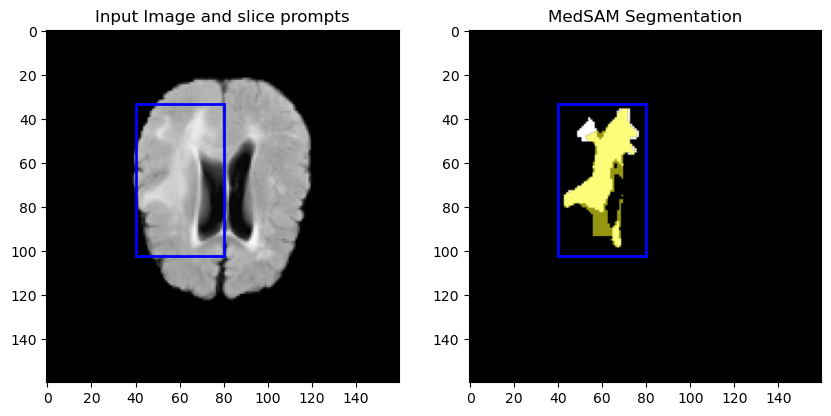

0.8072048032021347

In [3]:
slice_idx = 60
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, box_prompt= box_prompt)